# Endometriosis Detection

### 1. Exploring the dataset

The dataset contains images in .nii format which is a 3d MRI scan. Here i used nib library to view the slices of the scan.

There are 5 types of scans:
- ovaries
- uterus
- endometriosacs
- T1 fat saturated scans 
- T2 scans 

uterus and endometriosacs have 3 regions of interest separated through different scans and ovaries scan has one region of interest.

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from skimage import exposure
import cv2

In [2]:
base_path = 'UT-EndoMRI'
datasets = ['D1_MHS', 'D2_TCPW']
results = []

In [3]:
print("=== Dataset Composition ===")
for dataset in datasets:
    patient_dirs = [d for d in os.listdir(os.path.join(base_path, dataset)) if d.startswith(dataset[:2])]
    print(f"{dataset}: {len(patient_dirs)} patients")

    # Count available sequences per patient
    for patient in tqdm(patient_dirs[:5], desc=f"Sampling {dataset}"):  # Sample first 5 patients
        patient_path = os.path.join(base_path, dataset, patient)
        files = os.listdir(patient_path)

        sequences = [f.split('_')[1].split('.')[0] for f in files if '_' in f and 'r' not in f]
        labels = [f.split('_')[1].split('.')[0] for f in files if '_' in f and any(s in f for s in ['ut', 'ov', 'em', 'cy', 'cds'])]

        results.append({
            'dataset': dataset,
            'patient': patient,
            'sequences': sequences,
            'labels': labels,
            'num_sequences': len(sequences),
            'num_labels': len(labels)
        })

# Convert to DataFrame for analysis
df = pd.DataFrame(results)

=== Dataset Composition ===
D1_MHS: 51 patients


Sampling D1_MHS: 100%|██████████| 5/5 [00:00<?, ?it/s]


D2_TCPW: 73 patients


Sampling D2_TCPW: 100%|██████████| 5/5 [00:00<00:00, 4988.47it/s]


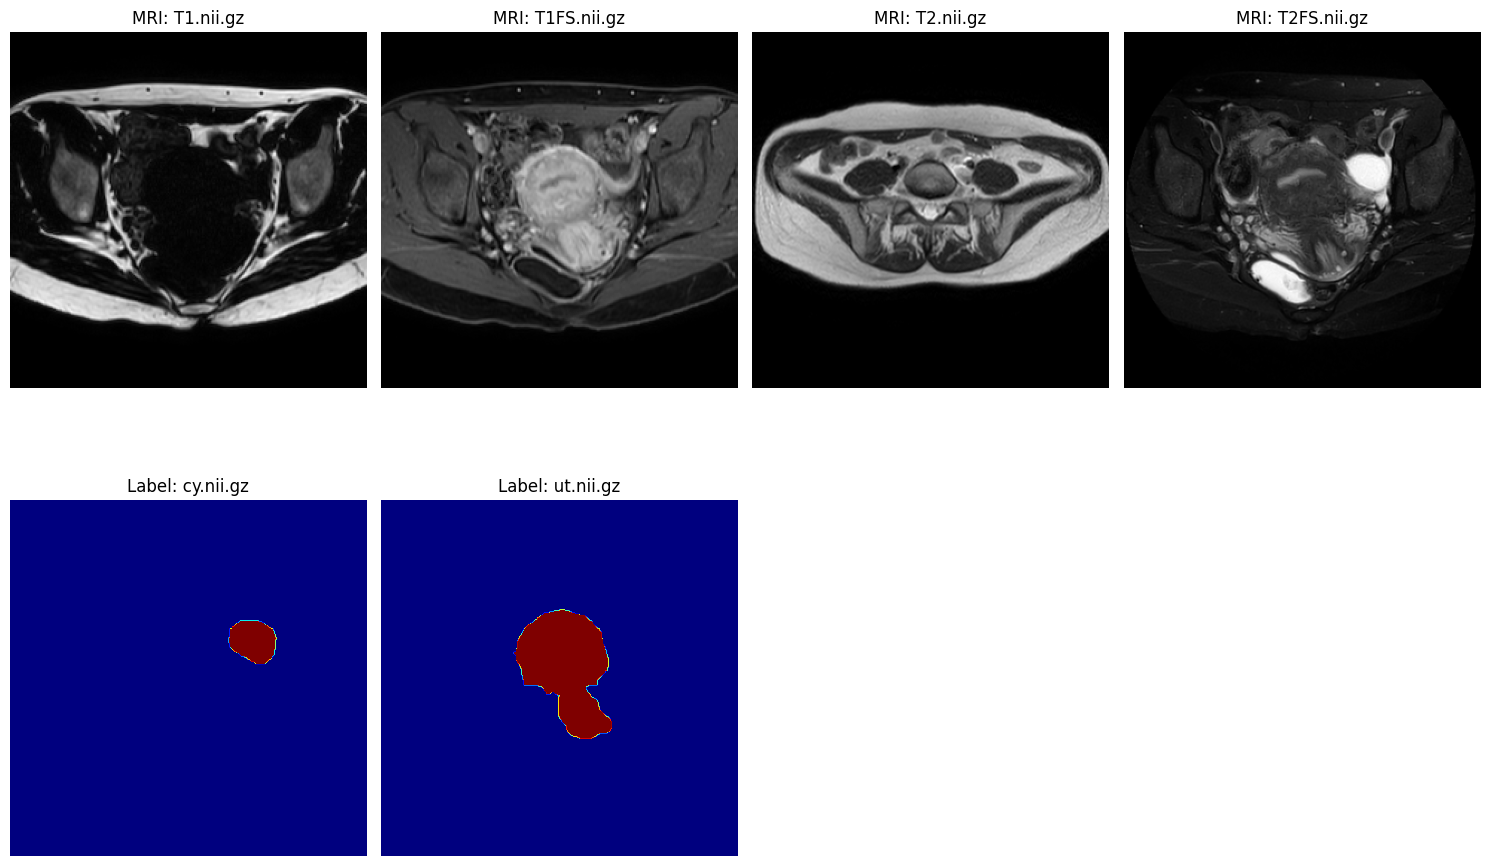

In [4]:
def visualize_patient(patient_path):
    """Visualize all available sequences and annotations for a patient"""
    files = os.listdir(patient_path)
    mri_files = [f for f in files if any(seq in f for seq in ['T1', 'T2', 'T1FS', 'T2FS'])]
    label_files = [f for f in files if any(seq in f for seq in ['ut', 'ov', 'em', 'cy', 'cds'])]

    plt.figure(figsize=(15, 10))

    # Load and display MRI sequences
    for i, mri_file in enumerate(mri_files[:4]):  # Show max 4 sequences
        img = nib.load(os.path.join(patient_path, mri_file)).get_fdata()
        mid_slice = img.shape[2] // 2

        plt.subplot(2, 4, i+1)
        plt.imshow(img[:, :, mid_slice].T, cmap='gray')
        plt.title(f"MRI: {mri_file.split('_')[1]}")
        plt.axis('off')

    # Load and display annotations
    for j, label_file in enumerate(label_files[:4]):  # Show max 4 labels
        label = nib.load(os.path.join(patient_path, label_file)).get_fdata()
        mid_slice = label.shape[2] // 2

        plt.subplot(2, 4, j+5)
        plt.imshow(label[:, :, mid_slice].T, cmap='jet')
        plt.title(f"Label: {label_file.split('_')[1]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample patient
sample_patient = os.path.join(base_path, 'D2_TCPW', 'D2-006')
visualize_patient(sample_patient)

Analyzing annotations: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


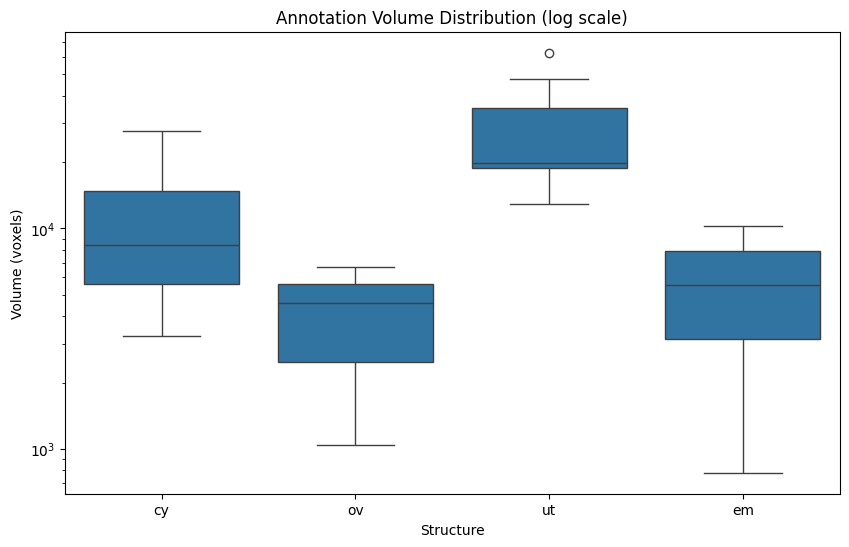

In [5]:
def analyze_annotations(dataset_path):
    """Quantitative analysis of annotation volumes"""
    volumes = []

    # Get only patient directories (filter out system files)
    patient_dirs = [d for d in os.listdir(dataset_path)
                   if d.startswith('D2-') and os.path.isdir(os.path.join(dataset_path, d))]

    for patient in tqdm(patient_dirs[:10], desc="Analyzing annotations"):  # Sample first 10 patients
        patient_path = os.path.join(dataset_path, patient)
        try:
            # Get only valid label files
            label_files = [f for f in os.listdir(patient_path)
                         if any(s in f for s in ['ut', 'ov', 'em', 'cy', 'cds'])
                         and f.endswith('.nii.gz')]

            if not label_files:
                print(f"No annotations found for patient {patient}")
                continue

            for label_file in label_files:
                try:
                    label = nib.load(os.path.join(patient_path, label_file)).get_fdata()
                    structure = label_file.split('_')[1].split('.')[0]
                    volumes.append({
                        'patient': patient,
                        'structure': structure,
                        'volume_voxels': np.sum(label > 0),
                        'volume_percent': 100 * np.mean(label > 0)
                    })
                except Exception as e:
                    print(f"Error processing {label_file} for patient {patient}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error processing patient {patient}: {str(e)}")
            continue

    if not volumes:
        print("No valid annotations found in the dataset")
        return None

    vol_df = pd.DataFrame(volumes)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=vol_df, x='structure', y='volume_voxels')
    plt.yscale('log')
    plt.title('Annotation Volume Distribution (log scale)')
    plt.ylabel('Volume (voxels)')
    plt.xlabel('Structure')
    plt.show()

    return vol_df

# Run the analysis with error handling
try:
    vol_df = analyze_annotations(os.path.join(base_path, 'D2_TCPW'))
except Exception as e:
    print(f"Error during annotation analysis: {str(e)}")
    vol_df = None

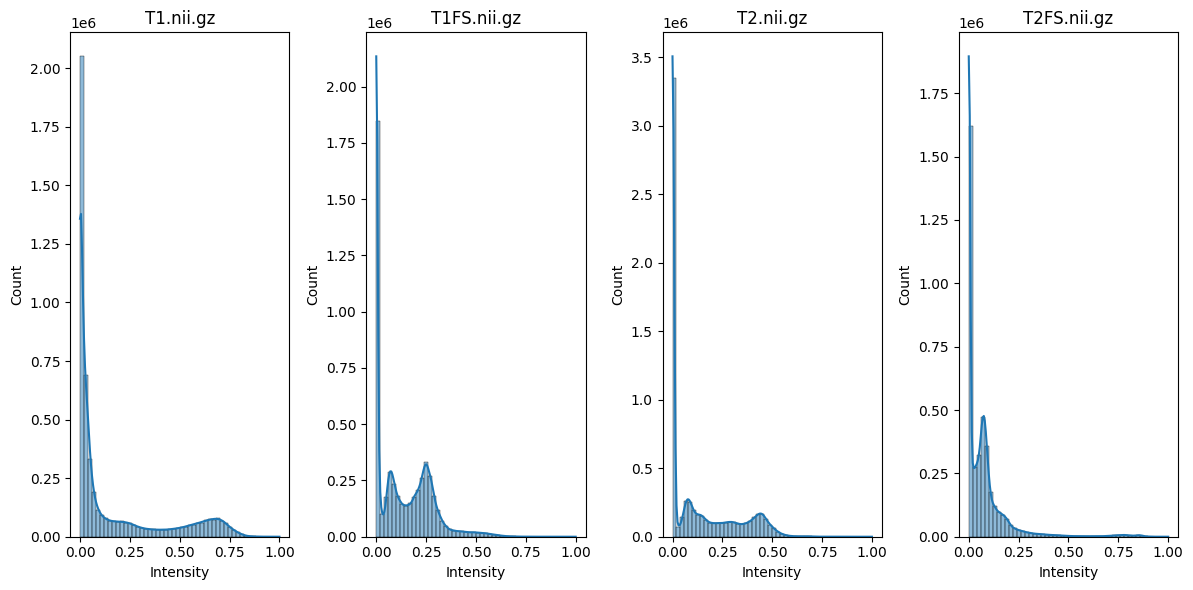

In [6]:
def analyze_intensity_distribution(patient_path):
    """Analyze intensity distribution across sequences"""
    files = [f for f in os.listdir(patient_path) if any(seq in f for seq in ['T1', 'T2', 'T1FS', 'T2FS'])]

    plt.figure(figsize=(12, 6))
    for i, mri_file in enumerate(files):
        img = nib.load(os.path.join(patient_path, mri_file)).get_fdata()
        normalized = exposure.rescale_intensity(img, out_range=(0, 1))

        plt.subplot(1, len(files), i+1)
        sns.histplot(normalized.flatten(), bins=50, kde=True)
        plt.title(f"{mri_file.split('_')[1]}")
        plt.xlabel('Intensity')

    plt.tight_layout()
    plt.show()

analyze_intensity_distribution(sample_patient)

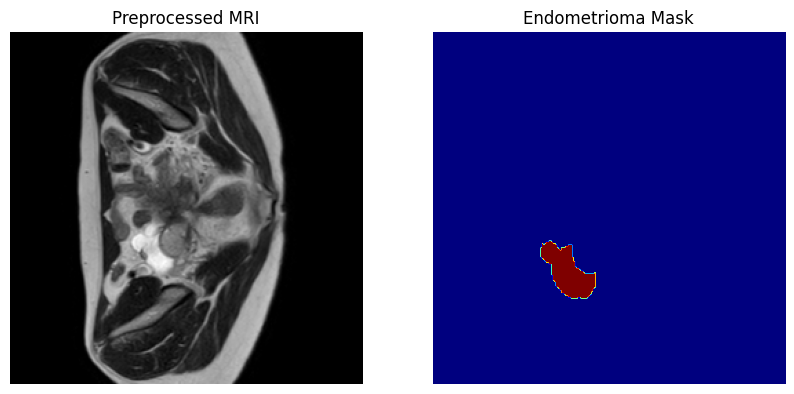

In [7]:
def preprocess_for_gradcam(patient_path, target_size=(256, 256)):
    """Preprocess MRI and annotations for GRAD-CAM analysis"""
    mri_file = [f for f in os.listdir(patient_path) if 'T2' in f and 'FS' not in f][0]
    img = nib.load(os.path.join(patient_path, mri_file)).get_fdata()
    
    label_files = [f for f in os.listdir(patient_path) if any(lbl in f for lbl in ['em','ut','ov','cy','cds'])]
    if not label_files:
        print("No annotation found for this patient")
        return None, None

    label = nib.load(os.path.join(patient_path, label_files[0])).get_fdata()
    slice_idx = np.argmax(np.sum(label, axis=(0, 1)))
    img_slice = img[:, :, slice_idx]
    label_slice = label[:, :, slice_idx]

    img_normalized = cv2.normalize(img_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    img_resized = cv2.resize(img_normalized, target_size)

    label_resized = cv2.resize(label_slice.astype(np.float32), target_size)
    label_binary = (label_resized > 0.5).astype(np.uint8)

    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    img_rgb = img_rgb / 255.0  # Scale to [0,1]

    return img_rgb, label_binary

input_img, target_mask = preprocess_for_gradcam(sample_patient)

if input_img is not None:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_img)
    plt.title('Preprocessed MRI')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(target_mask, cmap='jet')
    plt.title('Endometrioma Mask')
    plt.axis('off')
    plt.show()

In [8]:
print("\n=== Dataset Statistics Summary ===")
print(f"Total patients analyzed: {len(df)}")
print("\nSequence availability:")
print(df['sequences'].explode().value_counts())

print("\nLabel availability:")
print(df['labels'].explode().value_counts())

print("\nAnnotation volume statistics:")
print(vol_df.groupby('structure')['volume_voxels'].describe())


=== Dataset Statistics Summary ===
Total patients analyzed: 10

Sequence availability:
sequences
T2      10
T1FS     8
T1       5
ut       5
T2FS     5
cy       3
ov       3
Name: count, dtype: int64

Label availability:
labels
ut    20
ov    15
em    10
cy     3
Name: count, dtype: int64

Annotation volume statistics:
           count          mean           std      min       25%      50%  \
structure                                                                  
cy           4.0  11977.750000  10946.653442   3254.0   5576.00   8440.0   
em           2.0   5539.500000   6730.949450    780.0   3159.75   5539.5   
ov           7.0   4059.714286   2221.179020   1039.0   2479.50   4584.0   
ut          10.0  27899.300000  16309.739197  12934.0  18758.50  19785.0   

                75%      max  
structure                     
cy         14841.75  27777.0  
em          7919.25  10299.0  
ov          5573.00   6690.0  
ut         35294.00  62632.0  


### 2. Preprocessing

In [9]:
import nibabel as nib
import numpy as np
import imageio,os

In [10]:
import os, nibabel as nib, numpy as np, imageio

base_dir = r"C:\Users\devgo\Documents\GitHub\Endometriosis-detection\UT-EndoMRI\D1_MHS"
dest_root = r"C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed"

for idx in range(0, 51):
    ogpath = os.path.join(base_dir, f"D1-{idx:03d}")
    destpath = os.path.join(dest_root, f"D1-{idx:03d}")
    os.makedirs(destpath, exist_ok=True)

    if not os.path.exists(ogpath):
        print(f" Skipping {ogpath} (folder not found)")
        continue

    nii_files = [f for f in os.listdir(ogpath) if f.endswith(".nii") or f.endswith(".nii.gz")]
    
    for nii in nii_files:
        nii_path = os.path.join(ogpath, nii)
        img = nib.load(nii_path)
        data = img.get_fdata()

        # Normalize 0–255
        data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255
        fname = os.path.splitext(nii)[0]
        
        start, end = int(data.shape[2] * 0.3), int(data.shape[2] * 0.7)
        saved_count = 0
        for slice_idx in range(start, end):
            slice_img = data[:, :, slice_idx]

            #  Skip empty/black slices
            if np.sum(slice_img) == 0:
                continue  

            out_path = os.path.join(destpath, f"{fname}_slice{slice_idx}.png")
            imageio.imwrite(out_path, slice_img.astype(np.uint8))
            saved_count += 1

        print(f"Saved {saved_count} non-empty slices from {nii} → {destpath}")


✅ Saved 4 non-empty slices from D1-000_em_r1.nii.gz → C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed\D1-000
✅ Saved 7 non-empty slices from D1-000_em_r2.nii.gz → C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed\D1-000
✅ Saved 4 non-empty slices from D1-000_em_r3.nii.gz → C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed\D1-000
✅ Saved 7 non-empty slices from D1-000_ov_r1.nii.gz → C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed\D1-000
✅ Saved 13 non-empty slices from D1-000_T1FS.nii.gz → C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed\D1-000
✅ Saved 13 non-empty slices from D1-000_T2.nii.gz → C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed\D1-000
✅ Saved 4 non-empty slices from D1-000_ut_r1.nii.gz → C:\Users\devgo\Documents\GitHub\Endometriosis-detection\D1_MHS_preprocessed\D1-000
✅ Saved 8 non-empty slices from D1-000_ut_r

In [10]:
import os
import numpy as np
import nibabel as nib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
DATA_ROOT = r"C:\Users\devgo\Documents\GitHub\Endometriosis-detection\UT-EndoMRI"  # root folder containing D1_MHS, D2_TCPW
DATASETS = ["D1_MHS", "D2_TCPW"]
CHOSEN_SEQUENCE = "T1FS"   # or "T1FS" or whatever sequence you prefer

TARGET_SHAPE = (128, 128, 64)  # (height, width, depth) adjust depending on memory/GPU
CHANNELS = 1

BATCH_SIZE = 2  # small if using large 3D data
EPOCHS = 15
SEED = 42

In [12]:
def load_nifti(path):
    img = nib.load(path)
    data = img.get_fdata()
    return data

def normalize_volume(vol):
    # Handle min == max
    vmin = np.min(vol)
    vmax = np.max(vol)
    if vmax - vmin == 0:
        return np.zeros_like(vol, dtype=np.float32)
    norm = (vol - vmin) / (vmax - vmin)
    return norm.astype(np.float32)

def resize_volume(vol, target_shape=TARGET_SHAPE):
    """
    Resize 3D volume to target_shape.
    Here simple approach: resize each slice in (H, W), then handle depth (D).
    """
    import cv2
    h, w, d = vol.shape
    # Resize each slice in H, W
    resized = []
    for i in range(d):
        slice_ = vol[:, :, i]
        slice_resized = cv2.resize(slice_, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)
        resized.append(slice_resized)
    vol_resized = np.stack(resized, axis=-1)  # shape: (H, W, d)
    # Now adjust depth
    if vol_resized.shape[2] >= target_shape[2]:
        vol_resized = vol_resized[:, :, :target_shape[2]]
    else:
        pad_depth = target_shape[2] - vol_resized.shape[2]
        # pad zeros at end
        vol_resized = np.pad(vol_resized, ((0,0), (0,0), (0,pad_depth)), mode='constant', constant_values=0)
    return vol_resized

def get_subject_label(subject_folder, dataset_name):
    """
    Return 1 if `em` mask present with >0 voxels, else 0.
    """
    # find mask file
    subj_path = os.path.join(DATA_ROOT, dataset_name, subject_folder)
    mask_candidates = []
    for fname in os.listdir(subj_path):
        # look for `*_em*.nii.gz`
        if fname.startswith(subject_folder) and ("_em" in fname) and fname.endswith(".nii.gz"):
            mask_candidates.append(fname)
    if not mask_candidates:
        return 0
    # load first mask and check if any voxel is non-zero
    mask_path = os.path.join(subj_path, mask_candidates[0])
    mask_vol = load_nifti(mask_path)
    # if any voxel > 0 → positive
    if np.any(mask_vol > 0):
        return 1
    else:
        return 0


In [13]:
subjects = []
labels = []

for ds in DATASETS:
    ds_path = os.path.join(DATA_ROOT, ds)
    for subject in os.listdir(ds_path):
        subject_folder = os.path.join(ds_path, subject)
        if not os.path.isdir(subject_folder):
            continue
        # check if the chosen MRI sequence exists
        mri_fname = f"{subject}_{CHOSEN_SEQUENCE}.nii.gz"
        mri_path = os.path.join(subject_folder, mri_fname)
        if not os.path.exists(mri_path):
            # Might try alternate sequence or skip
            continue
        
        # get label
        label = get_subject_label(subject, ds)
        subjects.append((mri_path, ds, subject))
        labels.append(label)

print("Total subjects loaded:", len(subjects))
print("Labels distribution:", np.bincount(labels))


Total subjects loaded: 104
Labels distribution: [60 44]


In [14]:
import numpy as np

np.savez("subjects_labels.npz", subjects=subjects, labels=labels)

# Load back
data = np.load("subjects_labels.npz", allow_pickle=True)
subjects = data["subjects"]
labels = data["labels"]


In [15]:
train_subj, test_subj, y_train, y_test = train_test_split(
    subjects, labels, test_size=0.2, random_state=SEED, stratify=labels
)

In [16]:
def make_dataset(subject_list, label_list):
    Xs = []
    Ys = []
    for (mri_path, ds, subject), lab in zip(subject_list, label_list):
        vol = load_nifti(mri_path)
        vol = normalize_volume(vol)
        vol = resize_volume(vol, TARGET_SHAPE)
        # add channel
        vol = vol[..., np.newaxis]
        Xs.append(vol)
        Ys.append(lab)
    Xs = np.array(Xs)
    Ys = np.array(Ys)
    return Xs, Ys

X_train, Y_train = make_dataset(train_subj, y_train)
X_test, Y_test = make_dataset(test_subj, y_test)

print("X_train shape:", X_train.shape, "Y_train:", Y_train.shape)

X_train shape: (83, 128, 128, 64, 1) Y_train: (83,)


In [17]:
X_test.shape

(21, 128, 128, 64, 1)

In [26]:
input_shape = X_train.shape[1:]  # (H, W, D, 1)

model = models.Sequential([
    layers.Conv3D(16, (3,3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling3D((2,2,2)),
    layers.Conv3D(32, (3,3,3), activation='relu'),
    layers.MaxPooling3D((2,2,2)),
    layers.Conv3D(64, (3,3,3), activation='relu'),
    layers.MaxPooling3D((2,2,2)),
    layers.GlobalAveragePooling3D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 126, 126, 62,   │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 63, 63, 31, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 61, 61, 29, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 30, 30, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 28, 28, 12, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 14, 14, 6, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,113 (305.13 KB)

 Trainable params: 78,113 (305.13 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=BATCH_SIZE
)

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.4284 - auc: 0.3286 - loss: 0.6997 - val_accuracy: 0.6471 - val_auc: 0.5000 - val_loss: 0.6882
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.5827 - auc: 0.3986 - loss: 0.6911 - val_accuracy: 0.6471 - val_auc: 0.4394 - val_loss: 0.6835
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.4749 - auc: 0.6637 - loss: 0.6940 - val_accuracy: 0.6471 - val_auc: 0.5152 - val_loss: 0.6758
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.5900 - auc: 0.3219 - loss: 0.6902 - val_accuracy: 0.6471 - val_auc: 0.4621 - val_loss: 0.6682
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.4359 - auc: 0.5104 - loss: 0.7083 - val_accuracy: 0.6471 - val_auc: 0.5379 - val_loss: 0.6726
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6384 - auc: 0.5066 - loss: 0.6954 - val_accuracy: 0.6471 - val_auc: 0.5379 - val_loss: 0.6712
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s

In [30]:
model.save('endo.keras')

In [28]:
test_loss, test_acc, test_auc = model.evaluate(X_test, Y_test, batch_size=1)
print("Test Accuracy:", test_acc, "Test AUC:", test_auc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9434 - auc: 0.9320 - loss: 0.4589
Test Accuracy: 0.9047619104385376 Test AUC: 0.9722222089767456


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow import keras

# ---------------------------
# Load trained model
# ---------------------------
model = keras.models.load_model("endo.keras")

# ---------------------------
# Prepare test data
# ---------------------------
X_test, Y_test = make_dataset(test_subj, y_test)

# If labels are one-hot encoded, convert back to integers
if len(Y_test.shape) > 1 and Y_test.shape[1] > 1:
    y_true = np.argmax(Y_test, axis=1)
else:
    y_true = Y_test

# ---------------------------
# Evaluate model
# ---------------------------
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print(f"\n✅ Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

# ---------------------------
# Predictions
# ---------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# ---------------------------
# Metrics
# ---------------------------
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# ---------------------------
# Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step - accuracy: 0.9048 - auc: 0.9722 - loss: 0.5253


ValueError: too many values to unpack (expected 2)